In [12]:
import d2l

In [13]:
import math
import time
import numpy as np 
import torch
from d2l import torch as d2l

In [14]:
def normal(x, mu, sigma):
    p = 1/math.sqrt(2*math.pi*sigma**2)
    return p*np.exp(-0.5 * (x-mu)**2/sigma**2)

In [15]:
x = np.arange(-7,7,0.01)
x

array([-7.  , -6.99, -6.98, ...,  6.97,  6.98,  6.99])

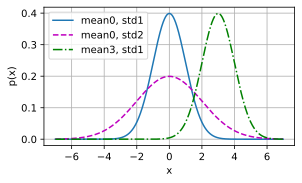

In [16]:
params = [(0,1),(0,2),(3,1)]
d2l.plot(x, [normal(x, mu, sigma) for mu,sigma in params], xlabel='x',
         ylabel='p(x)',figsize=(4.5, 2.5),
         legend=[f'mean{mu}, std{sigma}' for mu, sigma in params])

In [17]:
import time 
import numpy as np
import torch
from torch import nn 
from d2l import torch as d2l

In [18]:
# utility to set functions as methods after a class is created

def add_to_class(Class):
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

In [19]:
class A:
    def __init__(self):
        self.b = 1

a = A()

In [20]:
@add_to_class(A)
def do(self):
    print('Class attribute "b" is', self.b)

a.do()

Class attribute "b" is 1


In [21]:
#utility class that saves all args in a class's __init__ method as class attribute

class HyperParameters:
    def save_hyperparameters(self, ignore=[]):
        raise NotImplemented

In [22]:
class B(d2l.HyperParameters):
    def __init__(self, a,b,c):
        self.save_hyperparameters(ignore=['c'])
        print('self.a = ', self.a, 'self.b =', self.b)
        print('There is no self.c=', not hasattr(self, 'c'))
b = B(a=1,b=2,c=3)

self.a =  1 self.b = 2
There is no self.c= True


In [23]:
class ProgressBoard(d2l.HyperParameters):  #@save
    """The board that plots data points in animation."""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

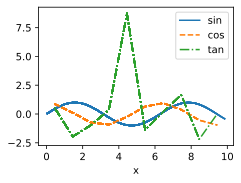

In [24]:
board = d2l.ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=10)
    board.draw(x, np.tan(x), 'tan', every_n=10)

In [25]:
class Module(nn.Module, d2l.HyperParameters):
    def __init__(self, plot_train_per_epoch = 2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard()
    def loss(self, y_hat, y):
        raise NotImplemented
    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural netweok is defined'
        return self.net(X)
    def plot(self, key, value, train):
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                        ('train_' if train else 'val_') + key,
                        every_n= int(n))
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l
    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)
    def configure_optimizers(self):
        raise NotImplemented
    

In [26]:
class DataModule(d2l.HyperParameters):
    def __init__(self, root='../data', num_workers = 4):
        self.save_hyperparameters()
    def get_dataloader(self, train):
        raise NotImplemented
    def train_dataloader(self):
        return self.get_dataloader(train = True)
    def val_dataloader(self):
        return self.get_dataloader(train=False)

In [27]:
class Trainer(d2l.HyperParameters):
    def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
        self.save_hyperparameters()
        assert num_gpus == 0, 'No GPU support Yet'
    
    def prepare_data(self, data):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)
    def prepare_model(self, model):
        model.trainer = self
        model.board.xlim = [0,self.max_epochs]
        self.model = model
    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()
    def fit_epoch(self):
        raise NotImplemented

# Synthetic Regression Data

In [28]:
import random

In [29]:
class SyntheticRegressionData(d2l.DataModule):
    def __init__(self,w,b,noise=0.01,num_train=1000,num_val=1000,
                 batch_size = 32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train+num_val
        self.X = torch.randn(n, len(w))
        noise = torch.randn(n,1)*noise
        self.y = torch.matmul(self.X, w.reshape((-1,1))) + b + noise

In [30]:
data = SyntheticRegressionData(w=torch.tensor([2,-3.4]), b=4.2)

In [31]:
print('features:', data.X[0], '\nlabel:', data.y[0])  

features: tensor([-1.1374, -1.4151]) 
label: tensor([6.7291])


In [32]:
@d2l.add_to_class(SyntheticRegressionData)

def get_dataloader(self,train):
    if train:
        indices = list(range(0,self.num_train))
        random.shuffle(indices)
    else:
        indices = list(range(self.num_train, self.num_train+self.num_val))
    for i in range(0,len(indices), self.batch_size):
        batch_indices = torch.tensor(indices[i:i+self.batch_size])
        yield self.X[batch_indices], self.y[batch_indices]

In [33]:
X,y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


In [34]:
@d2l.add_to_class(d2l.DataModule)
def get_tensorloader(self, tensors, train, indices=slice(0,None)):
    tensors = tuple(a[indices] for a in tensors)
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)

@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

In [35]:
X,y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


In [36]:
len(data.train_dataloader())

32

In [37]:
class LinearRegressionScratch(d2l.Module):
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0,sigma,(num_inputs,1), requires_grad=True)
        self.b = torch.zeros(1,requires_grad=True)

In [38]:
@d2l.add_to_class(LinearRegressionScratch)
def forward(self, X):
    return torch.matmul(X, self.w)+self.b

In [39]:
@d2l.add_to_class(LinearRegressionScratch)
def loss(self,y_hat,y):
    l = ((y_hat-y)**2) / 2
    return l.mean()

In [40]:
class SGD(d2l.HyperParameters):
    def __init__(self, params, lr):
        self.save_hyperparameters()
    
    def step(self):
        for param in self.params:
            param -= self.lr * param.grad
    
    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [41]:
@d2l.add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

In [42]:
@add_to_class(d2l.Trainer)
def prepare_batch(self, batch):
    return batch
@add_to_class(d2l.Trainer)
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:
                self.clip_gradient(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    
    if self.val_dataloader is None:
        return
    
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

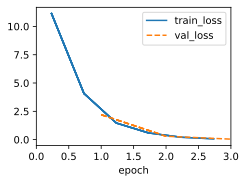

In [43]:
model = LinearRegressionScratch(2,lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2,-3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

In [44]:
with torch.no_grad():
    print(f'error in estmating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estmating b: {data.b - model.b}')

error in estmating w: tensor([ 0.0614, -0.1757])
error in estmating b: tensor([0.2242])


In [45]:
class LinearRegression(d2l.Module):
    def __init__(self,lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0,0.01)
        self.net.bias.data.fill_(0)

In [46]:
@d2l.add_to_class(LinearRegression)
def forward(self, X):
    return self.net(X)

@d2l.add_to_class(LinearRegression)
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

@d2l.add_to_class(LinearRegression)
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

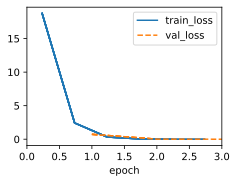

In [47]:
model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w = torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

In [48]:
@d2l.add_to_class(LinearRegression)  #@save
def get_w_b(self):
    return (self.net.weight.data, self.net.bias.data)
w, b = model.get_w_b()

print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')

error in estimating w: tensor([ 0.0018, -0.0109])
error in estimating b: tensor([0.0120])


In [2]:
import math
def euclid_dist(arr1, arr2):
    result = 0
    for i in range(len(arr1)):
        result += (arr1[i] - arr2[i])**2
    return math.sqrt(result)

In [50]:
euclid_dist([1,1], [0,0])

1.4142135623730951

In [3]:
var = [[185,72],[170,56],[168,60],[179,68],[182,72],[188,77]]

def dist_from_seedpoint(arr, seedpoint):
    cluster_dist = []
    for i in range(len(arr)):
        cluster_dist.append(euclid_dist(arr[i], seedpoint))
    return cluster_dist

In [7]:
dist_from_seedpoint(var, [169,58])

[21.2602916254693,
 2.23606797749979,
 2.23606797749979,
 14.142135623730951,
 19.1049731745428,
 26.870057685088806]

# Weight decay

In [53]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n,1) * 0.01
        w, b = torch.ones((num_inputs, 1))*0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

In [54]:
def l2_penalty(w):
    return (w**2).sum()/2

In [55]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()
    def loss(self, y_hat, y):
        return (super().loss(y_hat, y)+self.lambd*l2_penalty(self.w))

In [56]:
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5 )
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd= lambd, lr = 0.01)
    model.board.yscale='log'
    trainer.fit(model,data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

L2 norm of w: 0.009928024373948574


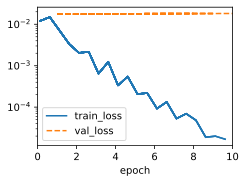

In [57]:
train_scratch(0)

L2 norm of w: 0.0011752869468182325


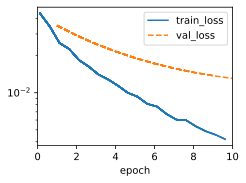

In [58]:
train_scratch(3)

In [59]:
class WeigthDecay(d2l.LinearRegression):
    def __init__(self, lr, wd):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd
    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}
        ], lr=self.lr)

L2 norm of w: 0.012014565989375114


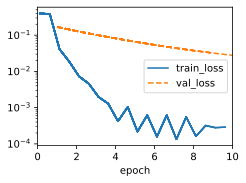

In [60]:
model = WeigthDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model,data)
print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

# Linear neural network for classification


### image classification dataset

In [61]:
import time
import torch
import torchvision
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [62]:
class FashionMNIST(d2l.DataModule):
    def __init__(self, batch_size=64, resize = (28,28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize), 
                                    transforms.ToTensor()])
        self.train = torchvision.datasets.FashionMNIST(
            root = self.root,
            train=True,
            transform=trans,
            download=True
        )
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root,
            train=False,
            transform=trans,
            download=True
        )

training -> 60000
test -> 10000

In [63]:
data = FashionMNIST(resize=(32,32))
len(data.train), len(data.val)

(60000, 10000)

In [64]:
data.train[0][0].shape

torch.Size([1, 32, 32])

In [65]:
@d2l.add_to_class(FashionMNIST)
def text_labels(self,indices):
    labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(i)] for i in indices]

### Reading minibatchs

In [66]:
@d2l.add_to_class(FashionMNIST)
def get_dataloader(self, train):
    data = self.train if train else self.val 
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers = self.num_workers)

In [67]:
X, y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)

torch.Size([64, 1, 32, 32]) torch.float32 torch.Size([64]) torch.int64


In [68]:
tic = time.time()
for X,y in data.train_dataloader():
    continue
f'{time.time() - tic:.2f} sec'

'7.06 sec'

### Visualization

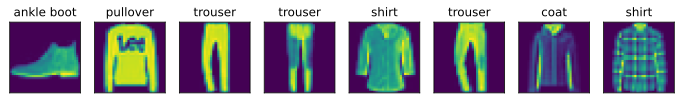

In [69]:
def show_image(imgs, num_rows, num_cols, titles = None, scale=1.5):
    raise NotImplementedError

@d2l.add_to_class(FashionMNIST)
def visualize(self, batch, nrows = 1, ncols=8, labels=[]):
    X,y = batch
    if not labels:
        labels = self.text_labels(y)
    d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)
batch = next(iter(data.val_dataloader()))
data.visualize(batch)

In [70]:
class Classifier(d2l.Module):
    def validation_step(self, batch):
        y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(y_hat, batch[-1]), train=False)

In [71]:
@d2l.add_to_class(d2l.Module)
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), lr = self.lr)

In [72]:
@d2l.add_to_class(Classifier)
def accuracy(self, y_hat, y, averaged=True):
    y_hat = y_hat.reshape((-1,y_hat.shape[-1]))
    preds = y_hat.argmax(axis=1).type(y.dtype)
    compare = (preds == y.reshape(-1)).type(torch.float32)
    return compare.mean() if averaged else compare

In [73]:
X = torch.tensor([[1.0,2.0,3.0], [4.0,5.0,6.0]])
X.sum(0, keepdims=True), X.sum(1, keepdims=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [74]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp/partition

In [75]:
X = torch.rand((2,5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.2637, 0.1583, 0.1802, 0.1523, 0.2455],
         [0.2102, 0.1572, 0.2061, 0.3015, 0.1249]]),
 tensor([1., 1.]))

## The Model

In [76]:
class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)
    
    def parameters(self):
        return [self.W, self.b]

In [77]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def forward(self, X):
    X = X.reshape((-1, self.W.shape[0]))
    return softmax(torch.matmul(X, self.W) + self.b)

In [78]:
y = torch.tensor([0,2])
y_hat = torch.tensor([[0.1,0.3,0.6],[0.3,0.2,0.5]])
y_hat[[0,1],y]

tensor([0.1000, 0.5000])

In [79]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))),y]).mean()

cross_entropy(y_hat, y)

tensor(1.4979)

In [80]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def loss(self, y_hat, y):
    return cross_entropy(y_hat, y)

### Training

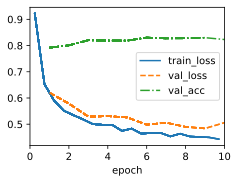

In [81]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [82]:
X, y = next(iter(data.val_dataloader()))
preds = model(X).argmax(axis=1)
preds.shape 

torch.Size([256])

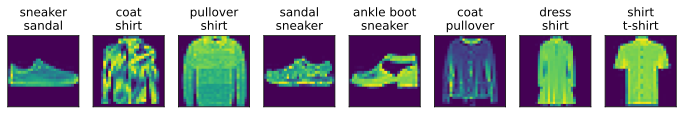

In [83]:
wrong = preds.type(y.dtype)!=y
X,y,preds = X[wrong], y[wrong], preds[wrong]
labels = [a+'\n'+b for a,b in zip(
    data.text_labels(y), data.text_labels(preds)
)]
data.visualize([X,y], labels=labels)

In [84]:
from torch.nn import functional as F

In [85]:
class SoftmaxRegression(d2l.Classifier):
    def __init__(self, num_outputs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_outputs))
    def forward(self, X):
        return self.net(X)

In [86]:
@d2l.add_to_class(d2l.Classifier)
def loss(self, y_hat, y, averaged=True):
    y_hat = y_hat.reshape((-1,y_hat.shape[-1]))
    y = y.reshape((-1))
    return F.cross_entropy(y_hat, y, reduction='mean' if averaged else 'none')

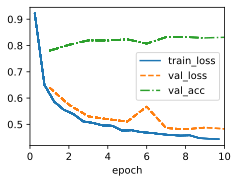

In [87]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegression(num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [88]:
%matplotlib inline
import torch
from d2l import torch as d2l

### Acitvation Functions

ReLU (Rectified Linear Unit):
- ReLU(x) = max(x,0)
- discards all negative elements

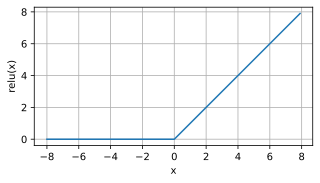

In [89]:
x = torch.arange(-8.0,8.0,0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5,2.5))

pReLU (parametrized ReLU):
- if negative = 0
- if positive = 1

pReLU(x) = max(0,x) + α min(0,x).

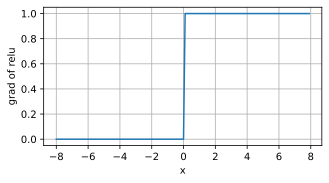

In [90]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5,2.5))

Sigmod Function:
- interval (0,1)
- a.k.a called "squashing function" and can squash inp in the range (-inf, inf) -> (0,1)
- sigmoid(x) = 1/(1+exp(-x))
- d(sigmod(x)) = exp(-x)/(1+exp(-x))^2 = sigmoid(x)(1-sigmoid(x))

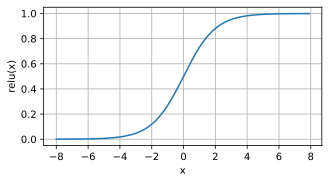

In [91]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5,2.5))

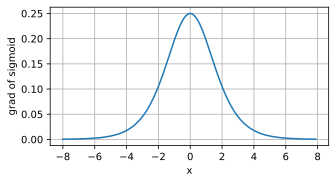

In [92]:
# reaches max of 0.25, and diverges from 0 in either direction

x.grad.data.zero_()
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5,2.5))

Tanh Function:
- tanh(x) = (1-exp(-2x))/(1+exp(-2x))
- squashes its inp into elements on the intervals between (-1,1)

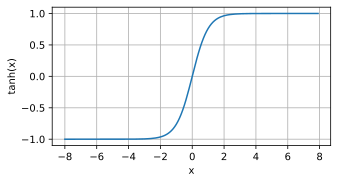

In [93]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5,2.5))

 - d(tanh(x)) = (1-tanh^2(x))

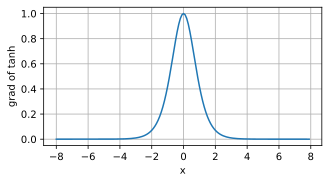

In [94]:
# approaches a max of 1
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

### Multilayer Perceptrons

In [101]:
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))

### Model

In [102]:
def relu(x):
    a = torch.zeros_like(X)
    return torch.max(X,a)

In [103]:
@add_to_class(MLPScratch)
def forward(self, X):
    X = X.reshape((-1, self.num_inputs))
    H = relu(torch.matmul(X, self.W1) + self.b1)
    return torch.matmul(H, self.W2) + self.b2

In [105]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1344x28 and 256x10)

In [108]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))

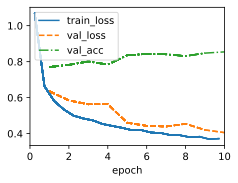

In [109]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

In [110]:
import torch
from torch import nn
from d2l import torch as d2l

In [111]:
def cpu():
    return torch.device('cpu')

def gpu(i=0):
    return torch.device(f'cuda:{i}')

cpu(), gpu(), gpu(1)

(device(type='cpu'),
 device(type='cuda', index=0),
 device(type='cuda', index=1))

In [114]:
def num_gpus():  #@save
    """Get the number of available GPUs."""
    return torch.cuda.device_count()
num_gpus()

0

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def corr2d(X, K):  #@save
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [3]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [4]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

In [5]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [6]:
K = torch.tensor([[1.0, -1.0]])

In [7]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [8]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [9]:
# Construct a two-dimensional convolutional layer with 1 output channel and a
# kernel of shape (1, 2). For the sake of simplicity, we ignore the bias here
conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # Learning rate

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # Update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 17.419
epoch 4, loss 6.116
epoch 6, loss 2.334
epoch 8, loss 0.927
epoch 10, loss 0.375


c:\Users\Admin\Desktop\sample_u_net_dataset\venv\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
